# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [0]:
#for axes: 0= lines, 1= column eg mean(x,axis=1) -> compute the mean over each line
#[begrow(included):endrow(excluded) , begcolums(included):endcolumn(excluded)] python slicing
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras import Model
from keras import backend as K

colab = True
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zerp-pad each sequence a length ```max_review_length````

In [0]:
top_words = 5000 
max_review_length = 100
INDEX_FROM = 3

## Import IMDB data

In [0]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
if colab==False:
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
else:
    # --- IF USING GOOGLE.COLAB
    # --- save np.load
    np_load_old = np.load
    # --- modify the default parameters of np.load 
    
    #np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k) #remplacé
    np.load.__defaults__ = (None,None,True,'ASCII')
    # --- call load_data with allow_pickle implicitly set to true
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
    # --- restore np.load for future normal usage
    np.load = np_load_old
    
    #at the end of this section, X_train will be an array where each element is a list containing the sequence of word's indexes representing reviews(bac,great,good ect..) for that particular movie

In [91]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [92]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

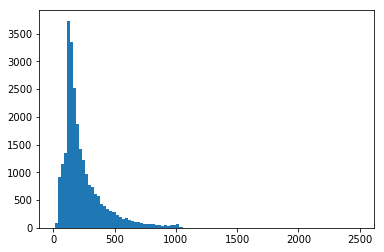

In [93]:
print("type(X_train):", type(X_train))
#the training input is actually an array where each element is a list(each list contains the words of the an input sequence)
print("number of training sequences: X_train.shape:", X_train.shape) 
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
len_list_test = [len(train) for train in X_test]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [94]:
#word_to_id is a map containig the word as key and the index as value and we skep the first 3 indexes in order to assign them to <PAD>, >START>, and <UNK>
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

#contains the mapping between word and id
id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [95]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [96]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [97]:
# --- truncate and pad input sequences

if student:
    # --- START CODE HERE (01)
    #this method will truncate each list in the array so that they have a length of 100 in order to be trained
    X_train = sequence.pad_sequences(X_train, maxlen =  max_review_length, dtype = "float32", padding = "pre", truncating = "pre", value = 0)
    X_test =  sequence.pad_sequences(X_test, maxlen =   max_review_length, dtype = "float32", padding = "pre", truncating = "pre", value = 0)
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1.415e+03 3.300e+01 6.000e+00 2.200e+01 1.200e+01 2.150e+02 2.800e+01
 7.700e+01 5.200e+01 5.000e+00 1.400e+01 4.070e+02 1.600e+01 8.200e+01
 2.000e+00 8.000e+00 4.000e+00 1.070e+02 1.170e+02 2.000e+00 1.500e+01
 2.560e+02 4.000e+00 2.000e+00 7.000e+00 3.766e+03 5.000e+00 7.230e+02
 3.600e+01 7.100e+01 4.300e+01 5.300e+02 4.760e+02 2.600e+01 4.000e+02
 3.170e+02 4.600e+01 7.000e+00 4.000e+00 2.000e+00 1.029e+03 1.300e+01
 1.040e+02 8.800e+01 4.000e+00 3.810e+02 1.500e+01 2.970e+02 9.800e+01
 3.200e+01 2.071e+03 5.600e+01 2.600e+01 1.410e+02 6.000e+00 1.940e+02
 2.000e+00 1.800e+01 4.000e+00 2.260e+02 2.200e+01 2.100e+01 1.340e+02
 4.760e+02 2.600e+01 4.800e+02 5.000e+00 1.440e+02 3.000e+01 2.000e+00
 1.800e+01 5.100e+01 3.600e+01 2.800e+01 2.240e+02 9.200e+01 2.500e+01
 1.040e+02 4.000e+00 2.260e+02 6.500e+01 1.600e+01 3.800e+01 1.334e+03
 8.800e+01 1.200e+01 1.600e+01 2.830e+02 5.000e+00 1.600e+01 4.472e+03
 1.130e+02 1.030e+02 3.

# First model

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [0]:
K.clear_session()

In [99]:
# --- create the model
embedding_vector_length = 32

# CODE-RNN1-2
if student:
    # --- START CODE HERE (02)
    # --- Using the Sequential API
    
    #till now we are using a sort one hot encoding where each word is represented by an index
    model = Sequential()
    #this layer takes as input a matrix of size input_dim*input_length and is able to to return a word embedding matrix of size input_dim*output_dim
    model.add(Embedding(input_dim = top_words, output_dim = embedding_vector_length,input_length = max_review_length))
    model.add(Lambda(lambda x: K.mean(x,axis =1) ))
    model.add(Dense(1, activation='sigmoid'))

    # --- END CODE HERE
    
    # --- START CODE HERE (03) just repeat the samething for model 2
    # --- Using the Functional API
    #NB: when using the input layer shape specify the shape of a single input in the format (seq_len,nLines) whcich is also the format used by model.summary
    inputs = Input(shape=(max_review_length,))

   # a layer instance is callable on a tensor, and returns a tensor
    output_1 =Embedding(input_dim = top_words, output_dim = embedding_vector_length,input_length = max_review_length)(inputs)
    output_2 =Lambda(lambda x : K.mean(x,axis =1))(output_1)
    outputs =Dense(1,activation= "sigmoid")(output_2)
    #outputs = Activation('sigmoid',name = "activation_layer")(output_3)
    model_functional = Model(inputs = inputs, outputs = outputs)
    #model = 
    # --- END CODE HERE
    

#the trainable parameters in the case of an RNN are the ones in the matrices W,Wax,wya
print(model.summary())
print(model_functional.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 32)           160000    
__________________________

In [100]:
#??? the loss is increasing and the accuracy is going down for the first model
# --- compile and fit the model 1
print("training model 1..........\n")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

print("training model........\n ")
# --- compile and fit the model 2
model_functional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_functional.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

training model 1..........

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 98us/step - loss: 0.6401 - acc: 0.7224 - val_loss: 0.5639 - val_acc: 0.7773
Epoch 2/10
25000/25000 [==============================] - 2s 89us/step - loss: 0.4876 - acc: 0.8154 - val_loss: 0.4405 - val_acc: 0.8186
Epoch 3/10
25000/25000 [==============================] - 2s 91us/step - loss: 0.3945 - acc: 0.8445 - val_loss: 0.3850 - val_acc: 0.8368
Epoch 4/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.3472 - acc: 0.8602 - val_loss: 0.3587 - val_acc: 0.8446
Epoch 5/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.3191 - acc: 0.8695 - val_loss: 0.3452 - val_acc: 0.8489
Epoch 6/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.2996 - acc: 0.8773 - val_loss: 0.3376 - val_acc: 0.8520
Epoch 7/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.2845 - acc: 0.8843 

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [101]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy for model 1: %.2f%%" % (scores[1]*100))

scores_functional_model = model_functional.evaluate(X_test, y_test, verbose=0)
print("Accuracy for model 2: %.2f%%" % (scores_functional_model[1]*100))

Accuracy for model 1: 85.44%
Accuracy for model 2: 85.41%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [102]:
if student:
    # print(model.parameters())
    # --- START CODE HERE (04)
    #get the weigths of a specific layer, in this case the embedding layer which is the first one
    E = model.get_weights()[0]
    
    position = word_to_id["great"]
    #convert great in one hot vector(of dimession 5000*1) and then get it's one hot encoding by multiplying it with the E(5000*32)
    x = np.zeros((5000,1), dtype = np.int)
    x[position] = 1
    word_embedding_great = np.dot(np.transpose(E),x)
    dist = np.linalg.norm(E[position:position+1] - E, axis=1)
    #print("word embedding of great \n",word_embedding_great)
    #find the index of the closes word in the norm array
    closest_word_index = np.where(dist ==  np.min(dist[np.nonzero(dist)]))[0][0]
    #convert it into a one hot encoding
    x = np.zeros((5000,1), dtype = np.int)
    x[position] = 1
   
    print("the closest word to great is :",id_to_word[closest_word_index])
    #print("\n the word embedding for that closest word is :\n")
    #print(np.dot(np.transpose(E),x))
   
    
    
    # --- END CODE HERE


the closest word to great is : fantastic


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=100$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [0]:
K.clear_session()

In [104]:
# --- create the model

if student:
    # --- START CODE HERE (05)
    # --- Using the Sequential API
    model = Sequential()
    model.add(Embedding(input_dim = top_words, output_dim = embedding_vector_length,input_length = max_review_length))
    model.add(LSTM(units = 100,return_sequences = False,name = "RNN1"))
    # model.add(Lambda(lambda x: K.mean(x,axis =1) ))
    model.add(Dense(1, activation='sigmoid'))
    # --- END CODE HERE
    
    # --- START CODE HERE (06)
    inputs = Input(shape=(max_review_length,))

    # a layer instance is callable on a tensor, and returns a tensor
    output_1 =Embedding(input_dim = top_words, output_dim = embedding_vector_length,input_length = max_review_length)(inputs)
    # output_2 =Lambda(lambda x : K.mean(x,axis =1))(output_1)
    output_2 = LSTM(units=100,return_sequences = False,name = "RNN1")(output_1)
    output_3 =Dense(1)(output_2)
    outputs = Activation('sigmoid',name = "activation_layer")(output_3)
    model_functional = Model(inputs = inputs, outputs = outputs)
    #model = 
    # --- END CODE HERE
   
print(model_functional.summary())
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
RNN1 (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_layer (Activation (None, 1)                 0         
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)              

In [105]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

# --- compile and fit the model 2(functional)
model_functional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_functional.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 67s 3ms/step - loss: 0.4421 - acc: 0.7866 - val_loss: 0.3402 - val_acc: 0.8499
Epoch 2/3
25000/25000 [==============================] - 66s 3ms/step - loss: 0.3085 - acc: 0.8710 - val_loss: 0.3458 - val_acc: 0.8506
Epoch 3/3
25000/25000 [==============================] - 66s 3ms/step - loss: 0.2665 - acc: 0.8908 - val_loss: 0.3473 - val_acc: 0.8478
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 67s 3ms/step - loss: 0.4396 - acc: 0.7860 - val_loss: 0.3592 - val_acc: 0.8426
Epoch 2/3
25000/25000 [==============================] - 66s 3ms/step - loss: 0.3089 - acc: 0.8725 - val_loss: 0.3596 - val_acc: 0.8436
Epoch 3/3
25000/25000 [==============================] - 66s 3ms/step - loss: 0.2706 - acc: 0.8916 - val_loss: 0.3587 - val_acc: 0.8500


## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [106]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 84.78%


# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data Pre-Processing (01)
- 2) First model using the Sequential API (02)
- 3) First model using the Functional API (03)
- 4) Find equivalence between words (04)
- 5) Second model using the Sequential API (05)
- 6) Second model using the Functional API (06)
